Лабораторная работа №8

In [2]:
!pip install neurolab
!pip install pyrenn
!pip install fireTS

import neurolab as nl
import numpy as np
import numpy.matlib
from sklearn.metrics import mean_squared_error
import pyrenn
from matplotlib import pyplot as plt
import math
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from sklearn.neural_network import MLPRegressor
from fireTS.models import NARX

##сеть прямого распространения с запаздыванием для предсказания временного ряда

число Вольфа

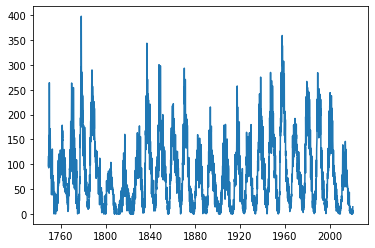

In [4]:
date =  "1847-02-01"
df = pd.read_csv('wolfie.csv', sep=';', header=None)
df = df.iloc[:, 0:4]
df[0] = df[0].astype(str)
df[1] = df[1].astype(str)
df.index = pd.to_datetime(df[0] + '-'+ df[1])
df.drop([0], axis=1, inplace=True)
df.drop([1], axis=1, inplace=True)
df.drop([2], axis=1, inplace=True)
df.head()

plt.plot(df)
plt.show()

выполняем сглаживание и формируем  тестовое множество

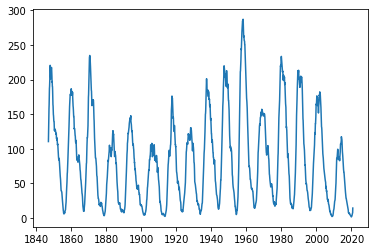

In [5]:
vals = df.values.flatten()
conv = np.convolve(vals, np.ones(12, dtype=int), 'valid') / 12    
r = np.arange(1, 11,2)
start = np.cumsum(vals[:(11)-1])[::2] / r
stop = (np.cumsum(vals[:-(11):-1])[::2] / r)[::-1]
smth_values = np.concatenate((start, conv, stop))

shift = df.values.size - smth_values.size
df.iloc[shift:] = smth_values[:, np.newaxis]
df = df[df.index >= pd.to_datetime(date)]
plt.plot(df)
plt.show()

In [6]:
deep = 5
split = int(len(df) * 0.7)
train = df[:split]
test = df[split:]

trainData = train.values.squeeze()
xTrain = np.array([trainData[i:i + deep] for i in range(len(trainData) - deep)])
yTrain = train.iloc[deep:].values

testData = test.values.squeeze()
xTest = np.array([testData[i:i + deep] for i in range(len(testData) - deep)])
yTest = test.iloc[deep:].values

сеть

In [122]:
model = Sequential()
model.add(Dense(8,activation='relu'))
model.add(Dense(8,))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(xTrain, yTrain, epochs=200)


Epoch 1/200
46/46 [==============================] - 1s 2ms/step - loss: 359.8732
Epoch 2/200
46/46 [==============================] - 0s 2ms/step - loss: 26.1237
Epoch 3/200
46/46 [==============================] - 0s 2ms/step - loss: 15.9936
Epoch 4/200
46/46 [==============================] - 0s 2ms/step - loss: 13.0779
Epoch 5/200
46/46 [==============================] - 0s 2ms/step - loss: 13.2409
Epoch 6/200
46/46 [==============================] - 0s 2ms/step - loss: 12.8893
Epoch 7/200
46/46 [==============================] - 0s 1ms/step - loss: 12.8909
Epoch 8/200
46/46 [==============================] - 0s 2ms/step - loss: 12.4244
Epoch 9/200
46/46 [==============================] - 0s 2ms/step - loss: 12.3220
Epoch 10/200
46/46 [==============================] - 0s 2ms/step - loss: 12.2778
Epoch 11/200
46/46 [==============================] - 0s 2ms/step - loss: 12.1994
Epoch 12/200
46/46 [==============================] - 0s 2ms/step - loss: 12.2823
Epoch 13/200
46/46 [====

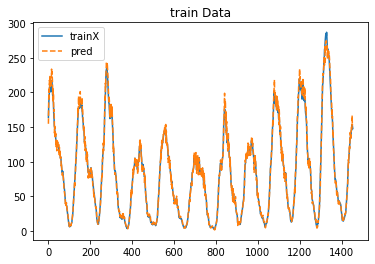

In [116]:
pred = model.predict(xTrain)
plt.plot(yTrain)
plt.plot(pred, '--')

plt.legend(['trainX', 'pred'])
plt.title("train Data")
plt.show()

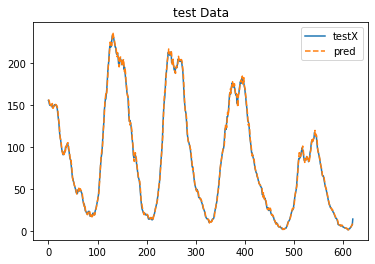

MSE = 7.66414349245747


In [94]:
pred = model.predict(xTest)
plt.plot(yTest)
plt.plot(pred, '--')

plt.legend(['testX', 'pred'])
plt.title("test Data")
plt.show()
MSE = mean_squared_error(yTest, pred)
print('MSE = {}'.format(MSE))

многошаговый прогноз

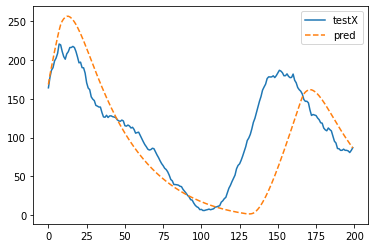

MSE = 2837.1032606716394


In [124]:
a = np.array(xTrain[0], ndmin=2)
preds = np.array([])
for i in range(200):
  pred = model.predict(a)
  a = np.append(a[:,1:], pred, axis=1)
  preds = np.append(preds, pred)

plt.plot(yTrain[:200])
plt.plot(preds, '--')

plt.legend(['testX', 'pred'])
plt.show()
MSE = mean_squared_error(yTrain[:len(preds)], preds)
print('MSE = {}'.format(MSE))


##сеть прямого распространения с распределенным запаздыванием для распознавания динамического образа

множества из лр №5

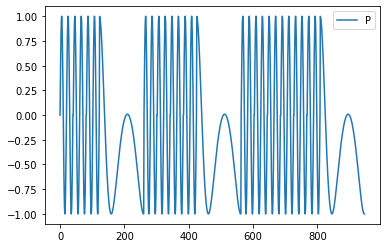

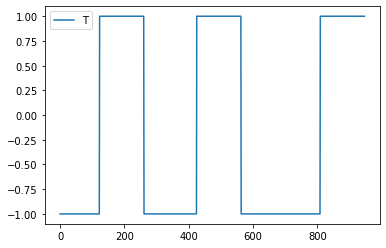

In [125]:
#основа
k1 = np.arange(0, 1+0.025, 0.025)
p = np.sin(4*np.pi*k1)
t1 = np.full(len(p),-1)

#для распознавания
k2 = np.arange(2.84, 6.25+0.025, 0.025)
g = np.sin(k2**2-10*k2+3)
t2 = np.full(len(g), 1)

R = [3,4,6]

P = np.array(np.append(np.append(np.append(np.append(np.append(np.matlib.repmat(p,1,R[0]), g), np.matlib.repmat(p,1,R[1])),g),np.matlib.repmat(p,1,R[2])),g),ndmin=2).reshape(-1,1)
T = np.array(np.append(np.append(np.append(np.append(np.append(np.matlib.repmat(t1,1,R[0]), t2), np.matlib.repmat(t1,1,R[1])),t2),np.matlib.repmat(t1,1,R[2])),t2),ndmin=2).reshape(-1,1)

plt.plot(P.reshape(len(P)))
plt.legend(['P'])
plt.show()
plt.plot(T.reshape(len(T)))
plt.legend(['T'])
plt.show()

сеть

In [126]:
T = T.ravel()
P = P.ravel()
nn = pyrenn.CreateNN([1, 8, 1], dIn=[5], dIntern=[5])
nn = pyrenn.train_LM(P, T, nn, E_stop=1e-5, k_max=100)

Maximum number of iterations reached


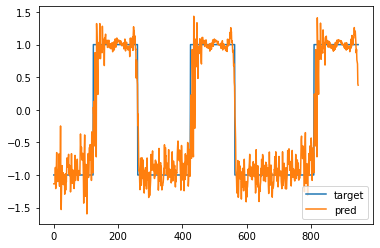

In [127]:
pred = pyrenn.NNOut(P, nn)
plt.plot(T)
plt.plot(pred)
plt.legend(['target', 'pred'])
plt.show()

In [128]:
out = [1 if(i>=0) else -1 for i in pred]
print('final accuracy = {}'.format((out == T.reshape(len(pred))).mean()))

final accuracy = 0.9831045406546991


проверка качества

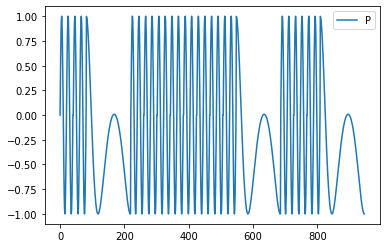

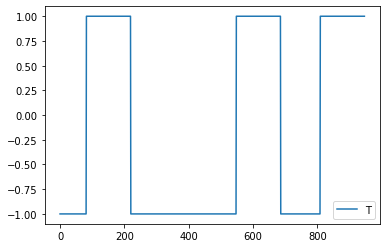

In [129]:
R = [2,8,3]

P = np.array(np.append(np.append(np.append(np.append(np.append(np.matlib.repmat(p,1,R[0]), g), np.matlib.repmat(p,1,R[1])),g),np.matlib.repmat(p,1,R[2])),g),ndmin=2).reshape(-1,1)
T = np.array(np.append(np.append(np.append(np.append(np.append(np.matlib.repmat(t1,1,R[0]), t2), np.matlib.repmat(t1,1,R[1])),t2),np.matlib.repmat(t1,1,R[2])),t2),ndmin=2).reshape(-1,1)

plt.plot(P.reshape(len(P)))
plt.legend(['P'])
plt.show()
plt.plot(T.reshape(len(T)))
plt.legend(['T'])
plt.show()

Maximum number of iterations reached


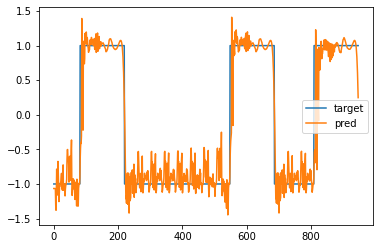

final accuracy = 0.9767687434002112


In [131]:
T = T.ravel()
P = P.ravel()
nn = pyrenn.CreateNN([1, 8, 1], dIn=[5], dIntern=[5])
nn = pyrenn.train_LM(P, T, nn, E_stop=1e-5, k_max=120)
pred = pyrenn.NNOut(P, nn)
plt.plot(T)
plt.plot(pred)
plt.legend(['target', 'pred'])
plt.show()
out = [1 if(i>=0) else -1 for i in pred]
print('final accuracy = {}'.format((out == T.reshape(len(pred))).mean()))

##нелинейная авторегрессионная сеть с внешними входами для аппроксимации траектории динамической системы

входные данные

In [132]:
def u(k):
    return np.cos(k**2) - np.cos(k)**2

def y_next(k):
    y = [0.]
    for i in k:
        y.append(y[-1] / (1 + y[-1]**2) + u(i)**3)
    return y[:-1]

k = np.arange(0, 10.01, 0.01)
y = y_next(k)
input = u(k)[:, np.newaxis] 
target = y
delay = 3

xTrain = k[:700]
xTest = k[700:900]
xValid = k[900:997]

yTrain = y[:700]
yTest = y[700:900]
yValid = y[900:997]


сеть

In [ ]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=600,
                         auto_order=2, exog_order=[2], exog_delay=[delay])

narx.fit(input, target)

In [134]:
output = narx.predict(input, target, step=1)
output[np.isnan(output)] = 0
MSE = mean_squared_error(target, output)
print('MSE = {}'.format(MSE))

MSE = 0.0015206396833412023


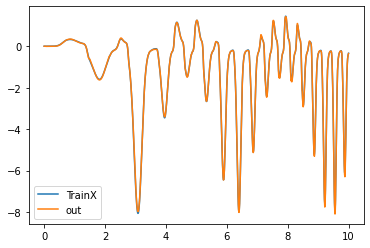

In [135]:
plt.plot(k, y)
plt.plot(k, output)
plt.legend(['TrainX', 'out'])
plt.show()

многошаговый прогноз

In [ ]:
narx = NARX(MLPRegressor(hidden_layer_sizes=(10, 10)), solver='lbfgs', max_iter=1000,
                         auto_order=2, exog_order=[delay], exog_delay=[delay])
narx.fit(input, target)


MSE = 0.48047937875731717


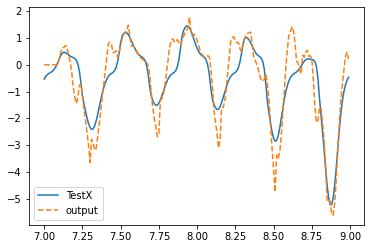

In [141]:
inputTest = u(xTest)[:, np.newaxis]
targetTest = yTest
out = narx.predict(inputTest, targetTest, step=5)
out[np.isnan(out)] = 0
MSE = mean_squared_error(targetTest, out)
print('MSE = {}'.format(MSE))
plt.plot(xTest, yTest)
plt.plot(xTest, out, '--')
plt.legend(['TestX', 'output'])
plt.show()